# Replication - High Dimensional Case2

Here we provide a notebook to replicate the simulation results for the high dimensional case2 simulation. 
As replicating all of the runs is rather time consuming, we provide this script to replicate a specified simulation run, which can then compared to the data provided on github.

The notebook replicates the results in:
- /out/simulation/sim_hd2

The main script can be found at: 
- /scripts/simulation/highdimensional_case2.py
- /scripts/simulation/highdimensional_case2.R



## Please choose the settup for replication:

In [1]:
run_id = 187 # any integer 1-200

In [2]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox

     |████████████████████████████████| 776.7 MB 4.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
     |████████████████████████████████| 607 kB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for probcox: filename=probcox-0.0.5-py3-none-any.whl size=5224 sha256=e0903b4fde303da880c575a1986ea44cff0b5e6622dfaf

In [3]:
# load R 
%load_ext rpy2.ipython

In [4]:
# install packages
%%R 
install.packages('survival')
install.packages('glmnet')
install.packages('coxed')
install.packages('ncvreg')
install.packages('doMC')
install.packages('BVSNLP')


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-13.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6545339 bytes (6.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [5]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(5462)
torch.manual_seed(785)

In [6]:
%%R -i run_id -o simdata

# Generate Data
set.seed(13)
library(survival)
library(glmnet)
library(doMC)
library(coxed)
library(ncvreg)
library(BVSNLP)

# generate paramters - 10 non -zero effects
theta <- c(-0.5, 0.7, 1.2, 0.65, -0.9, 1.4, 0.2, -0.4, -1.3, 0.1)
theta <- c(theta, replicate(990, 0))

# generate datasets
for(ii in seq(200)){
  simdata <- sim.survdata(N=750, T=10000, xvars=1000, censor=0.75, num.data.frames=1, beta=theta)$data
  if(ii==run_id){break}
}

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-3

R[write to console]: Loading required package: foreach

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rms

R[write to console]: Loading required package: Hmisc

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘Hmisc’


R[write to console]: The following objects are masked from ‘package:base’:

    format.pval, units


R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve


R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R

In [7]:

X = torch.from_numpy(np.asarray(simdata.iloc[:, :-2]).astype(float)).type(dtype)
surv = torch.from_numpy(np.concatenate((np.zeros((750, 1)), simdata.iloc[:, -2:]), axis=1).astype(float)).type(dtype)

total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()


In [8]:
# Inference Setup
# =======================================================================================================================
# Custom linear predictor - Here: simple linear combination
def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

def evaluate(surv, X, rank, batchsize, sampling_proportion, iter_, predictor=predictor):
    sampling_proportion[1] = batchsize
    eta=5 # paramter for optimization
    run = True # repeat initalization if NAN encounterd while training - gauge correct optimization settings
    while run:
        run = False
        pyro.clear_param_store()
        m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
        m.initialize(eta=eta, rank=rank, num_particles=5)
        loss=[0]
        for ii in tqdm.tqdm(range((iter_))):
            idx = np.unique(np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 1, replace=False), np.random.choice(range(surv.shape[0]), batchsize, replace=False))))[:batchsize] #  
            data=[surv[idx], X[idx]] # subsampled data
            loss.append(m.infer(data=data))
            # divergence check
            if loss[-1] != loss[-1]:
                eta = eta * 0.1
                run=True
                break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
    return(out)

In [9]:
# Run
# =======================================================================================================================

pyro.clear_param_store()
out5 = evaluate(rank=5, batchsize=256, iter_=15000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])

pyro.clear_param_store()
out50 = evaluate(rank=50, batchsize=256, iter_=15000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])


100%|██████████| 15000/15000 [08:01<00:00, 31.14it/s]


In [10]:

# Download data from github
# =======================================================================================================================

url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank5' +'_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank5' +'_theta_lower.txt'
url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank5' +'_theta_upper.txt'
theta_est5_sim = pd.read_csv(url1, header=None, sep=';')
theta_est5_lower_sim = pd.read_csv(url2, header=None, sep=';')
theta_est5_upper_sim = pd.read_csv(url3, header=None, sep=';')


url1 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank50' +'_theta.txt'
url2 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank50' +'_theta_lower.txt'
url3 = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/probcox' + 'rank50' +'_theta_upper.txt'
theta_est50_sim = pd.read_csv(url1, header=None, sep=';')
theta_est50_lower_sim = pd.read_csv(url2, header=None, sep=';')
theta_est50_upper_sim = pd.read_csv(url3, header=None, sep=';')


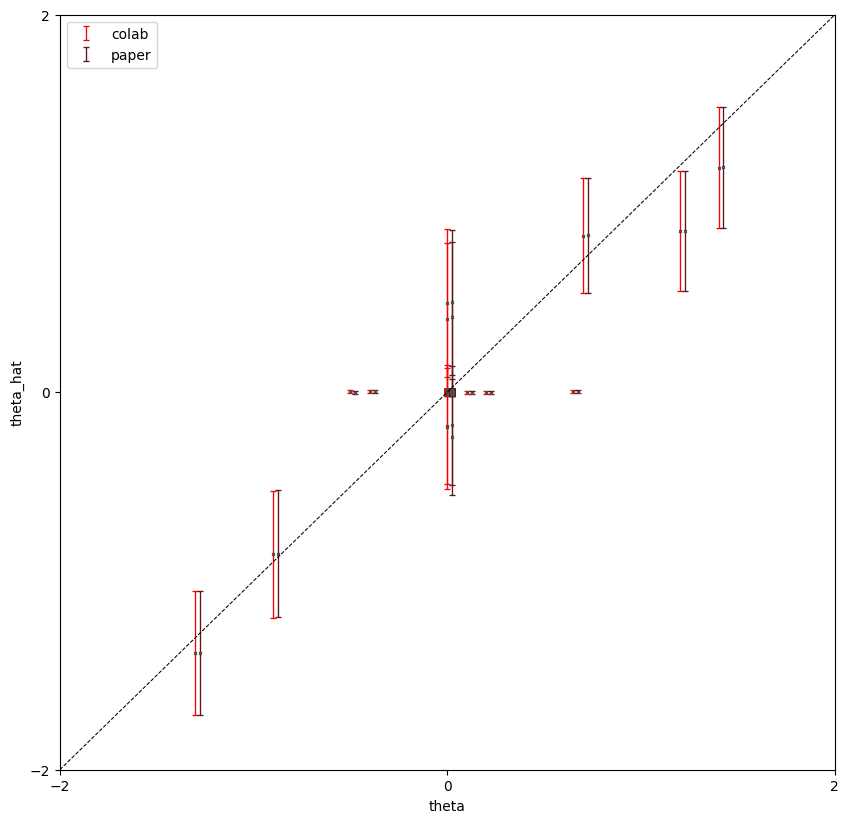

In [11]:
# Comparision - Plot
# =======================================================================================================================
theta = np.concatenate((np.asarray([-0.5, 0.7, 1.2, 0.65, -0.9, 1.4, 0.2, -0.4, -1.3, 0.1]), np.zeros((990,))))[:, None]
theta_est_sim = np.squeeze(np.asarray(theta_est5_sim.iloc[np.where(theta_est5_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_lower_sim = np.squeeze(np.asarray(theta_est5_lower_sim.iloc[np.where(theta_est5_lower_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_upper_sim = np.squeeze(np.asarray(theta_est5_upper_sim.iloc[np.where(theta_est5_upper_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]

theta_est = out5['theta'][1].detach().numpy()
theta_est_lower = out5['theta'][0].detach().numpy()
theta_est_upper = out5['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c="red", capsize=2, capthick=0.95, elinewidth=0.95, label='colab')

ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.errorbar(theta[:, 0]+0.025, theta_est_sim[:, 0], yerr=(theta_est_sim[:, 0] - theta_est_lower_sim[:, 0], theta_est_upper_sim[:, 0]- theta_est_sim[:, 0]),  ls='', c="#5c161e", capsize=2, capthick=0.95, elinewidth=0.95, label='paper')
ax.plot(theta[:, 0]+0.025, theta_est_sim[:, 0], ls='', c=".3", marker='x', ms=2)

ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.legend()
plt.show()
plt.close()

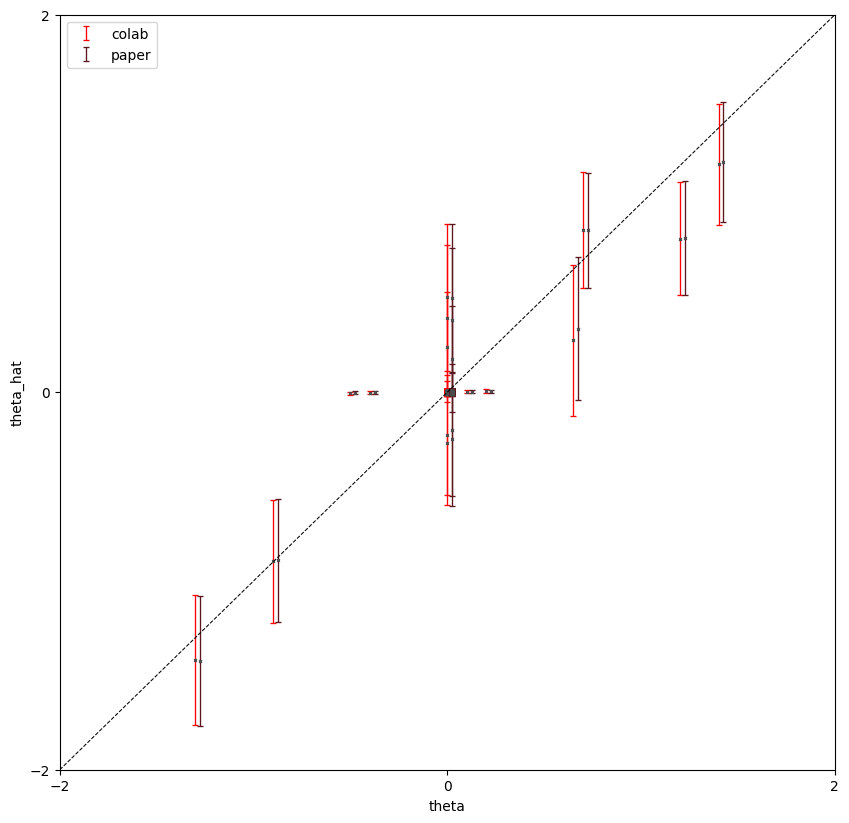

In [12]:
# Comparision - Plot
# =======================================================================================================================
theta = np.concatenate((np.asarray([-0.5, 0.7, 1.2, 0.65, -0.9, 1.4, 0.2, -0.4, -1.3, 0.1]), np.zeros((990,))))[:, None]
theta_est_sim = np.squeeze(np.asarray(theta_est50_sim.iloc[np.where(theta_est50_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_lower_sim = np.squeeze(np.asarray(theta_est50_lower_sim.iloc[np.where(theta_est50_lower_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]
theta_est_upper_sim = np.squeeze(np.asarray(theta_est50_upper_sim.iloc[np.where(theta_est50_upper_sim.iloc[:, 0] == run_id)[0], 1:-1]))[:, None]

theta_est = out50['theta'][1].detach().numpy()
theta_est_lower = out50['theta'][0].detach().numpy()
theta_est_upper = out50['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c="red", capsize=2, capthick=0.95, elinewidth=0.95, label='colab')

ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.errorbar(theta[:, 0]+0.025, theta_est_sim[:, 0], yerr=(theta_est_sim[:, 0] - theta_est_lower_sim[:, 0], theta_est_upper_sim[:, 0]- theta_est_sim[:, 0]),  ls='', c="#5c161e", capsize=2, capthick=0.95, elinewidth=0.95, label='paper')
ax.plot(theta[:, 0]+0.025, theta_est_sim[:, 0], ls='', c=".3", marker='x', ms=2)

ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.legend()
plt.show()
plt.close()

# R evaluation

In [13]:
%%R -o R_lasso -o R_lasso_1se -o R_Alasso1 -o R_Alasso1_1se -o R_Alasso2 -o R_Alasso2_1se -o R_SCAD -o R_MCP -o R_BVSNLP

sim <- simdata
yss = Surv(simdata$y, simdata$failed)

# Lasso 
cv.fit <- c()
cv.fit <- cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure ="C", alpha=1)
R_lasso <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
R_lasso_1se <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

w1 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.min)))
w1[w1 == Inf] <- 999999999 

w2 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.1se)))
w2[w2 == Inf] <- 999999999 

# Ridge 
#cv.fit <- c()
#cv.fit <- cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure ="C", alpha=0)
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_ridge_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_ridge_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")

#w3 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.min)))
#w3[w3 == Inf] <- 999999999 

#w4 <- 1/abs(as.numeric(coef(cv.fit, s=cv.fit$lambda.1se)))
#w4[w4 == Inf] <- 999999999 


# Adaptive Lasso
# Alasso 
cv.fit <- c()
cv.fit <-cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure="C", penalty.factor=w1)
R_Alasso1 <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
R_Alasso1_1se <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

# Alasso 2
cv.fit <- c()
cv.fit <-cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure="C", penalty.factor=w2)
R_Alasso2 <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.min)))
R_Alasso2_1se <- as.matrix(unname(coef(cv.fit, s=cv.fit$lambda.1se)))

# Alasso 3
#cv.fit <- c()
#cv.fit <-cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure="C", penalty.factor=w3)
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_Alasso3_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_Alasso3_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")

# Alasso 4
#cv.fit <- c()
#cv.fit <-cv.glmnet(as.matrix(sim[, 1:1000]), yss, family ="cox", nfolds=3, parallel=TRUE, type.measure="C", penalty.factor=w4)
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.min)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_Alasso4_theta.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")
#x = paste(sim_name, paste(unname(coef(cv.fit, s=cv.fit$lambda.1se)), collapse="; "), sep='; ')
#write(x, file = paste(ROOT_DIR, '/out/simulation/sim_hd2/R_Alasso4_theta_1se.txt', sep=''), ncolumns = 1, append = TRUE, sep = ";")

# SCAD
m <- cv.ncvsurv(as.matrix(sim[, 1:1000]), yss, penalty=c("SCAD"), nfolds=3, se=c('bootstrap'), trace=TRUE)
fit <- m$fit$beta[,m$min]
R_SCAD <- as.matrix(unname(m$fit$beta[,m$min]))

# MCP
m <- cv.ncvsurv(as.matrix(sim[, 1:1000]), yss, penalty=c("MCP"), nfolds=3, se=c('bootstrap'), trace=TRUE)
fit <- m$fit$beta[,m$min]
R_MCP <- as.matrix(unname(m$fit$beta[,m$min]))

# BVSNLP
bout <- bvs(sim[, 1:1000], yss, family = "survival", nlptype = "piMOM", niter = 2000, ncpu=8)
coef <- rep(0, 1000)
coef[bout$HPM] <- bout$beta_hat
R_BVSNLP <- as.matrix(unname(coef))




Starting CV fold #1
Starting CV fold #2
Starting CV fold #3
Starting CV fold #1
Starting CV fold #2
Starting CV fold #3


R_lasso


No handles with labels found to put in legend.


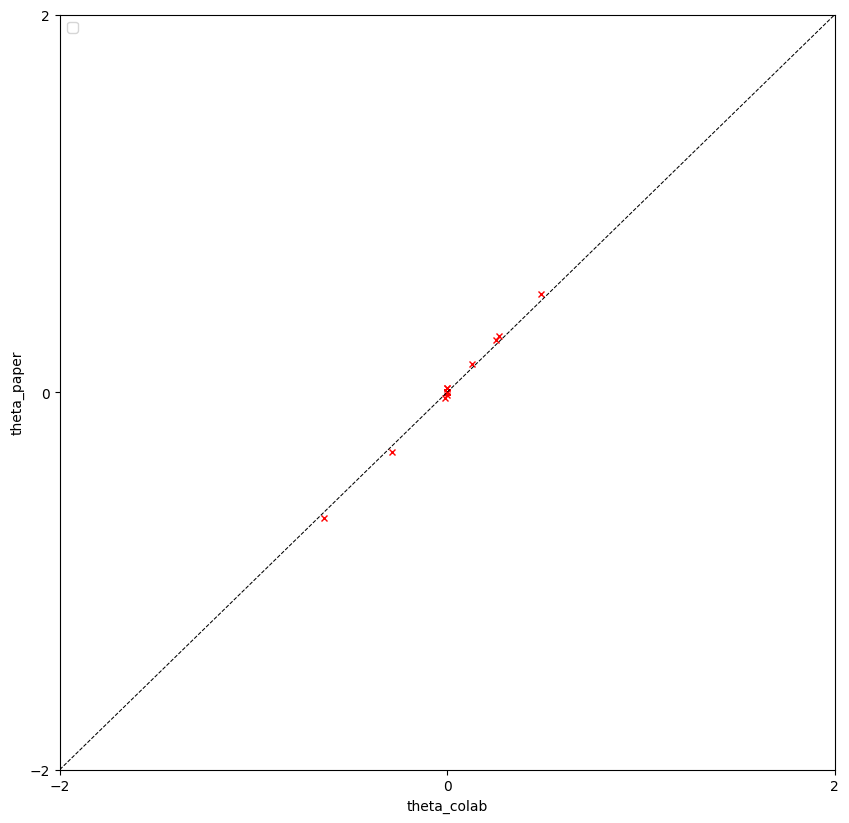

R_lasso_1se


No handles with labels found to put in legend.


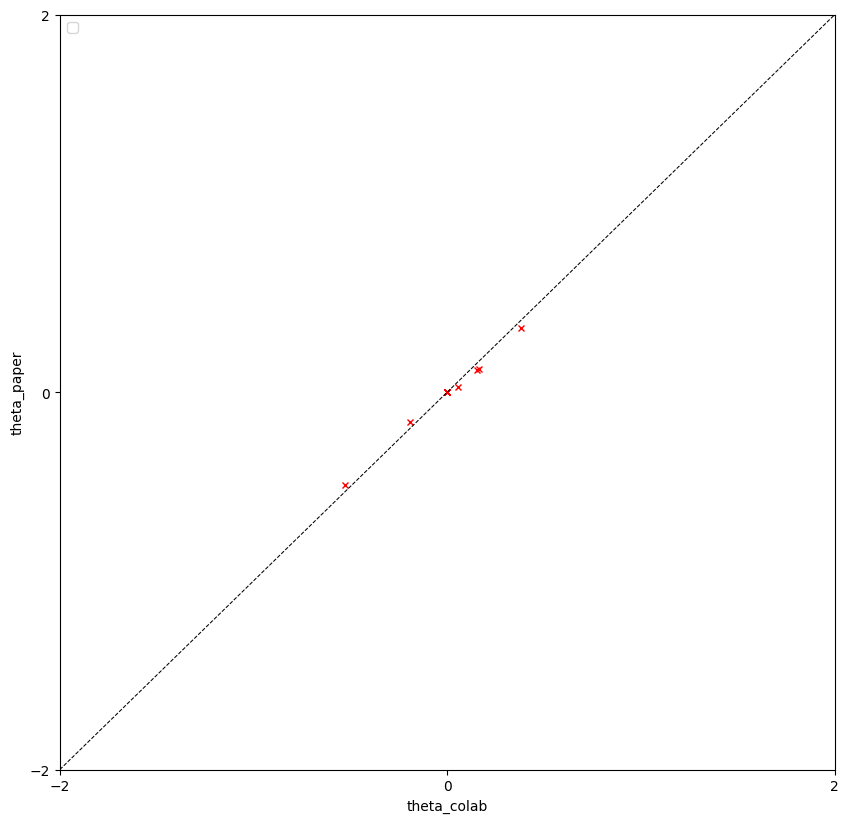

R_Alasso1


No handles with labels found to put in legend.


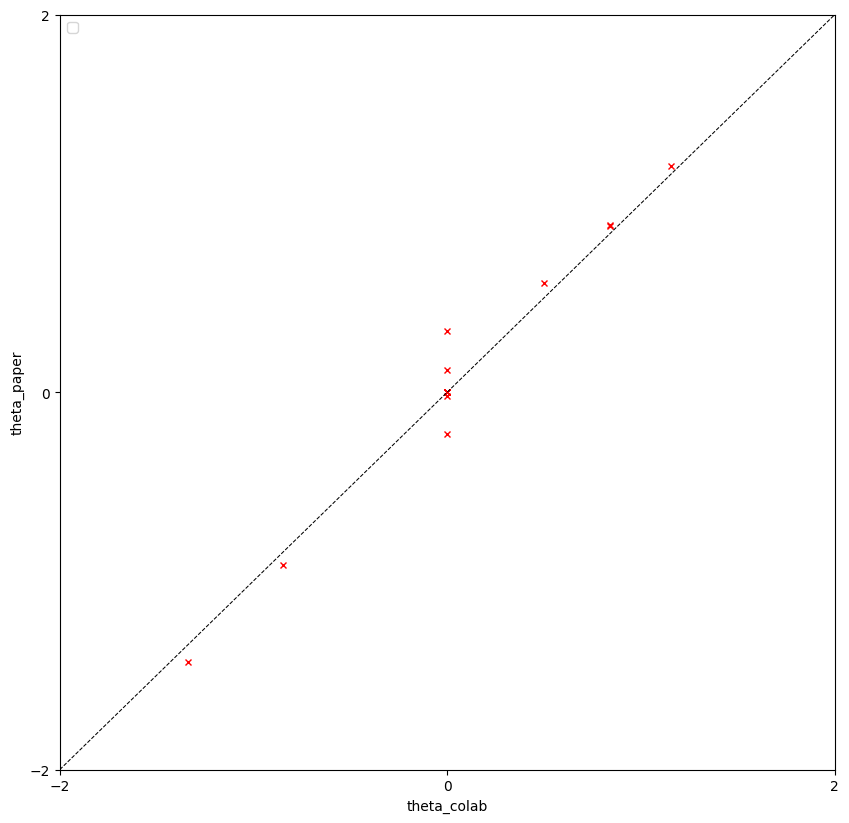

R_Alasso1_1se


No handles with labels found to put in legend.


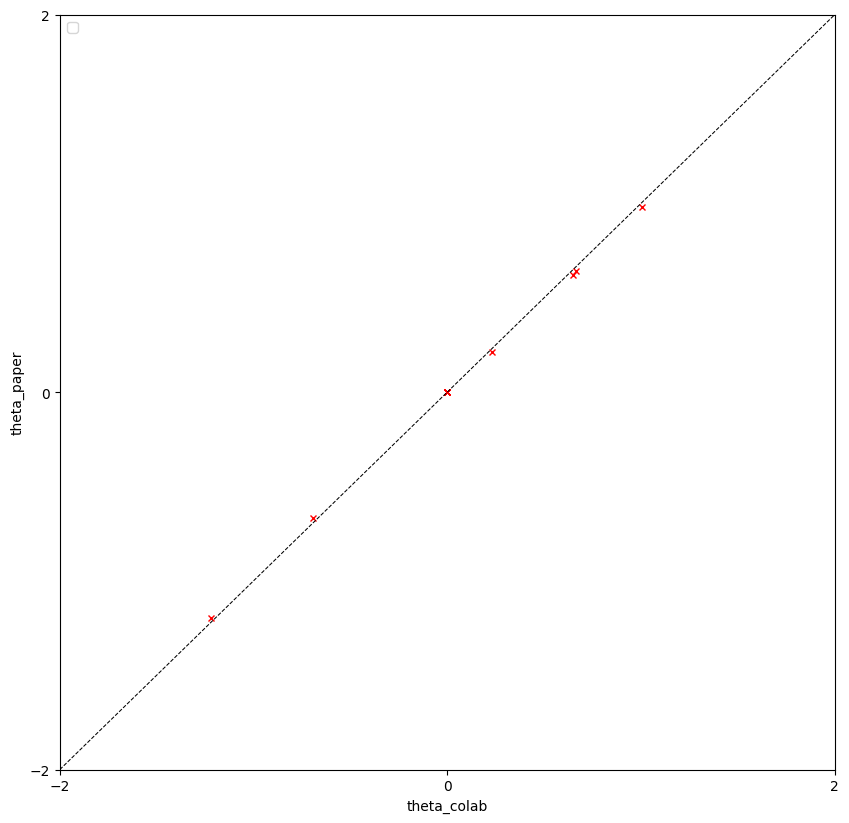

R_Alasso2


No handles with labels found to put in legend.


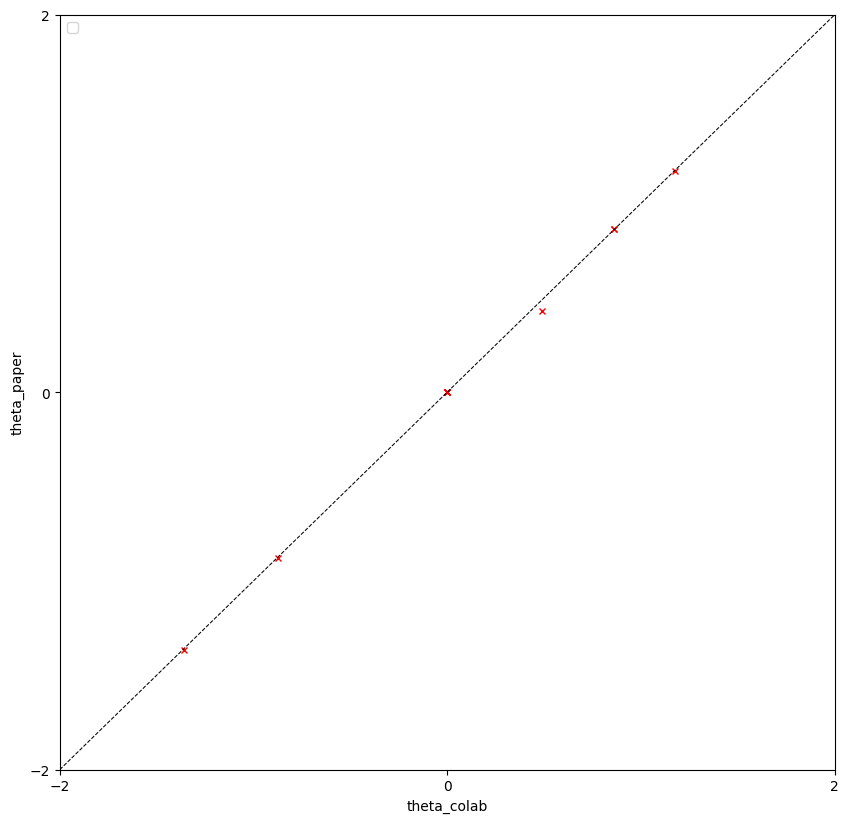

R_Alasso2_1se


No handles with labels found to put in legend.


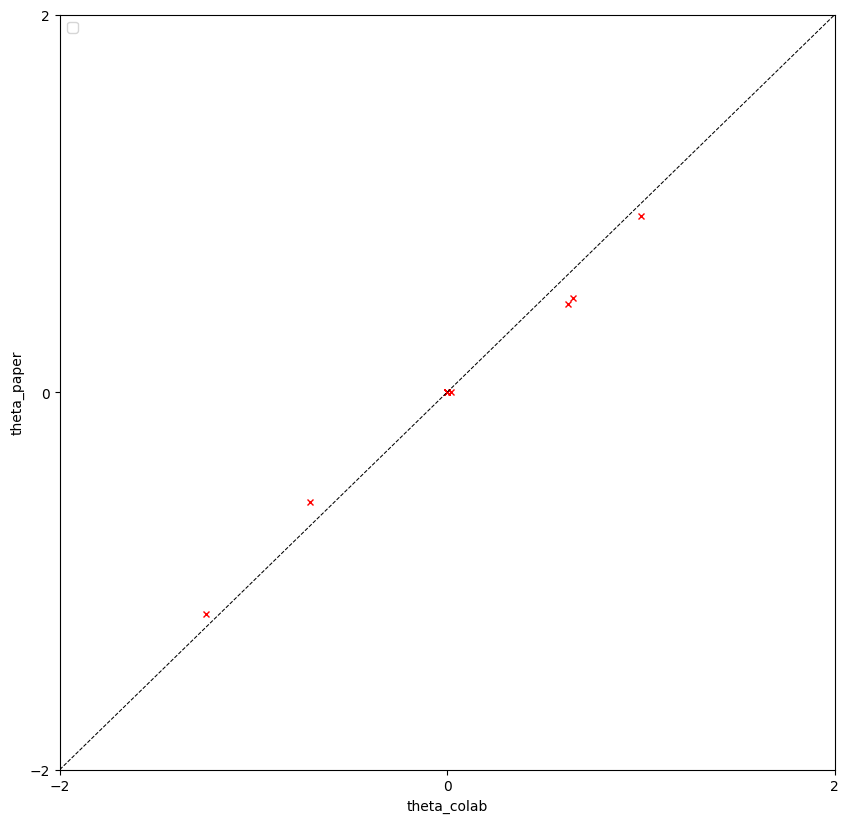

R_SCAD


No handles with labels found to put in legend.


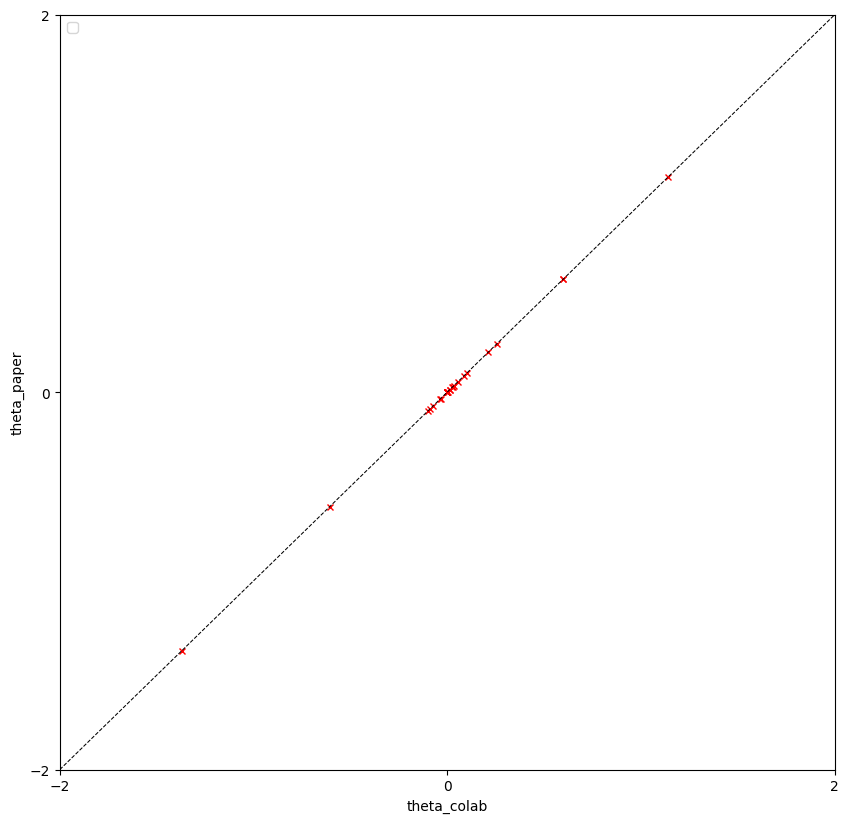

R_MCP


No handles with labels found to put in legend.


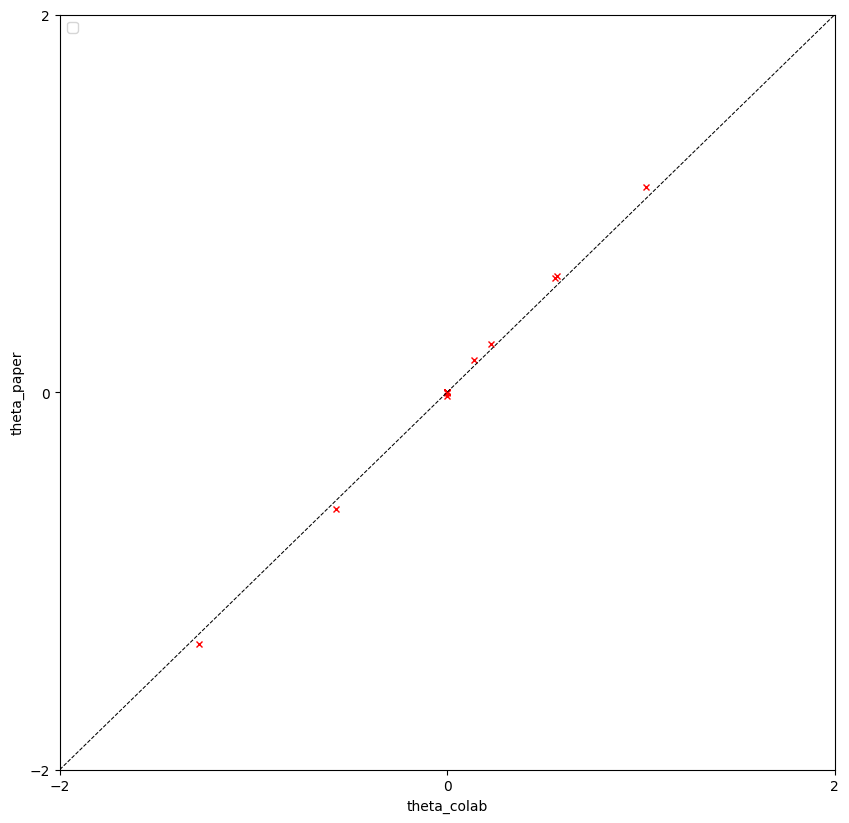

R_BVSNLP


No handles with labels found to put in legend.


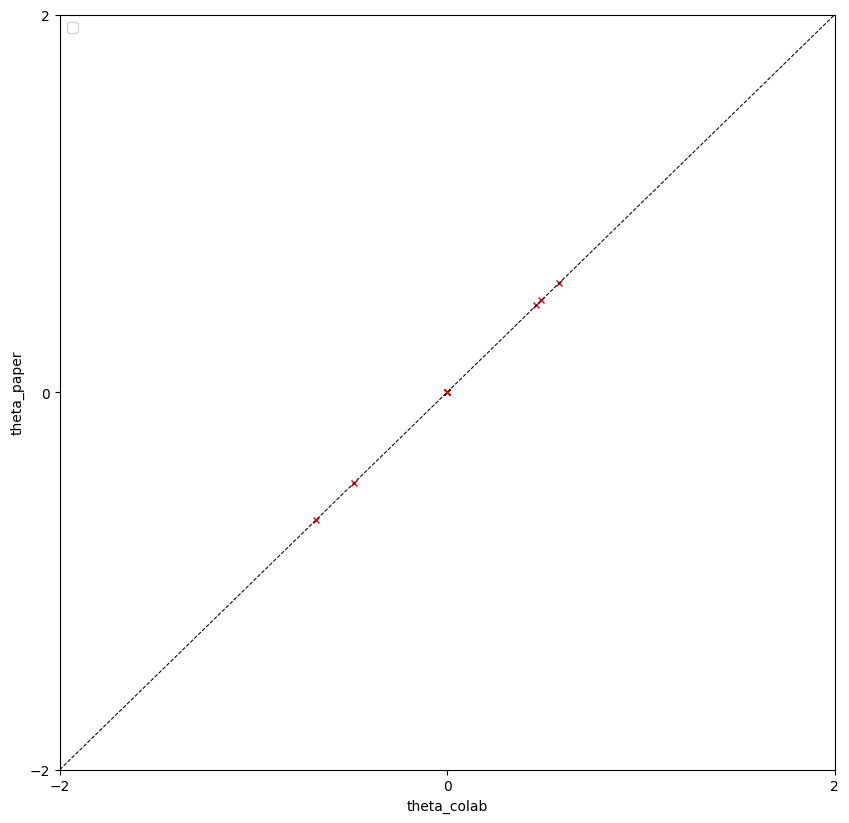

In [14]:

# Download data from github
# =======================================================================================================================
# choose any R model to load for comparison (need to select corresponding run id.)
Rsuffix_list = ['R_lasso_theta', 'R_lasso_theta_1se', 'R_Alasso1_theta', 'R_Alasso1_theta_1se', 'R_Alasso2_theta', 'R_Alasso2_theta_1se', 'R_SCAD_theta', 'R_MCP_theta', 'R_BVSNLP_theta']
Rmod_list = ['R_lasso', 'R_lasso_1se', 'R_Alasso1', 'R_Alasso1_1se', 'R_Alasso2', 'R_Alasso2_1se', 'R_SCAD', 'R_MCP', 'R_BVSNLP']

for ii in range(9):
  print(Rmod_list[ii])
  url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/out/simulation/sim_hd2/' + Rsuffix_list[ii] + '.txt'
  theta_R = pd.read_csv(url, header=None, sep=';')
  theta_R = np.asarray(theta_R.iloc[np.where(theta_R.iloc[:, 0]==run_id)[0], 1:]).T
  theta_colab = globals()[Rmod_list[ii]]

  fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
  ax.plot(theta_colab[:, 0], theta_R[:, 0], ls='', c="red", marker='x', ms=5)

  ax.set(xlim=(-2, 2), ylim=(-2, 2))
  ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="black", linewidth=0.75)
  ax.set_yticks([-2, 0, 2])
  ax.set_ylim([-2, 2])
  ax.set_xticks([-2, 0, 2])
  ax.set_xlim([-2, 2])
  ax.set_xlabel('theta_colab')
  ax.set_ylabel('theta_paper')
  plt.legend()
  plt.show()
  plt.close()


In [15]:
%%R
unregister_dopar <- function() {
  env <- foreach:::.foreachGlobals
  rm(list=ls(name=env), pos=env)
}